# Liver Cancer Patient Subtypes and their Respective Survival Rates

### Author: Shirley Wang

# Question

Are there distinct biological "subtypes" of patients with liver cancer that have different survival times? What impact does age at diagnosis, tumor stage, and sex have on the relationship between survival and subgroup?  For this report, I will be using hierarchical clustering to find subtypes of patients through their gene counts, and then conducting survival regression to see differences in survival and what factors have a significant effect on survival within the subgroups.

# Data

The data is gathered from the Genomic Data Commons website using The Cancer Genome Atlas (TCGA) transcriptome sequencing data for liver cancer.  There are 424 cases recorded, each with 60483 genes counted.  There is also 742 cases of clinical information regarding the patients in these cases with genome data.  The gene counts data is all positive and right-skewed, so I've added 1 to all of it and then taken the log to transform it to be more normal.

The variables of interest for the survival analysis are days_to_death, days_to_last_follow_up, and vital_status.  If a patient has died, their vital status is Dead, and I take their days_to_death as days survived, which records the number of days they lived after they were diagnosed.  If a patient has been censored, their vital status is Alive, and I take their days_to_last_follow_up as days survived, which records the last time the study checked the status of the patient and they were still alive.  There are twelve cases where both days_to_death and days_to_last_follow_up are missing, so I count those as outliers and removed them for the analysis.

The possible predictors of survival are age at diagnosis, tumor stage, and sex.  When viewing the clinical data in terms of only these predictors, the survival variables, plus the patient id they correspond to, their are duplicates of each case, so those have been removed.  Tumor stage has stages 1 to 4, with substages a, b, and c.  Due to the severe decrease in data in higher stages, with only 1 person at stage 4, I have collapsed all substages down into just the numbered stages.  There are also 24 cases of tumor stage not reported, so those have been removed for the survival regression portion.  

In [1]:
import glob
import lifelines as ll
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import sklearn.cluster as cluster

from IPython.display import display
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

np.random.seed(1) # otherwise clustering changes each time I restart the notebook
sns.set(style="whitegrid")

In [2]:
# get list of file names
genefilenames = glob.glob('a2data\genomicdata\**\*.gz', recursive = True)
# use \ turns into \\ on windows
# / works on linux though

# put in dataframe
gene_data = pd.DataFrame()
for name in genefilenames:
    genedat = pd.read_csv(name, sep = '\t', header = None, names = ['gene', 'rna'])
    genedat["log_rna"] = np.log(genedat["rna"] + 1)
    genedat.drop(columns=["rna"], inplace=True)
    genedat = genedat.set_index(keys="gene").T
    genedat.insert(0, "FileName", [name.split("\\")[3]])
    gene_data = gene_data.append(genedat)
    
gene_data.reset_index(inplace=True, drop=True)

In [3]:
# get links dataframe linking file name to file id
links = pd.read_csv('a2data/gdc_sample_sheet.2020-01-30.tsv', sep = '\t')

In [4]:
# get human clinical data on the people in the data
raw_clinical = pd.read_csv('a2data/clinicaldata/clinical.tsv', sep = '\t')

# save important rows
clinical = raw_clinical[['submitter_id', 'age_at_index','gender','vital_status', 
                         'days_to_death', 'days_to_last_follow_up', 'tumor_stage']]
clinical = clinical.rename(columns={"age_at_index": "DiagnosisAge", "gender": "Sex"})

# many of this subset of data is duplicated so get rid of the duplicates
clinical = clinical[clinical.duplicated()]
clinical = clinical.reset_index(drop=True)

In [5]:
# drop data with missing survival data
indices = clinical[(clinical["days_to_last_follow_up"] == "--") & (clinical["days_to_death"] == "--")].index
clinical = clinical.drop(indices)

# set age as number
clinical["DiagnosisAge"] = clinical["DiagnosisAge"].astype('int64')

# Methods

#### Part 1: Cluster Analysis. 

I will be using Principal Component Analysis to reduce the number of gene features and dimensionality of the data.  After that, using the PCA-transformed gene counts data, I will use hierarchical clustering to locate distinct clusters in the data.  Then using the measures of survival defined above, I will use a multivariate logrank test to compare the survival distributions between the clusters to see if they are significantly different or not.

#### Part 2: Survival Analysis

From the clusters found in part 1, I will use a Cox regression model for each group with the predictors DiagnosisAge, Sex, and TumorStage to see if any of the predictors are significant, and if the effects of the predictors are different from group to group.  I will also view the distributions of these variables in each group to see if the same type of people tend to end up in the same groups.

# Results

## Principal Component Analysis

In [6]:
genes = gene_data.reset_index(drop=True).drop(columns=["FileName"])
scaler = StandardScaler(with_std=False) # keep variance, scale means to 0
X = scaler.fit_transform(genes)

pca = PCA()
all_pca = pca.fit(X)

In [7]:
# pca variance explained plot
# removed for final report

#plt.plot(np.insert(np.cumsum(all_pca.explained_variance_ratio_), 0, 0))
#plt.xlabel('Number of Components')
#plt.ylabel('Cumulative Explained Variance')
#plt.title("PCA Variance Explained", fontsize=16)
#plt.show()

With just 50 components, 71.9% of the variation in the data is captured.  I will use the 50 PCA component transformed gene data for the clustering analysis, since a large portion of the variance is already captured and this way I avoid problems that come with working with incredibly high dimensional data.  I will also be using the 2 PCA component transformed gene data for graphing purposes, and with only 2 components, 25.7% of the variation in data is already captured, so the visualizations should be fair.

In [8]:
# 50 components for clustering
pca = PCA(n_components=50)
transformedX = pca.fit_transform(X)

# 2 components for graphing
pca = PCA(n_components=2)
graphingX = pca.fit_transform(X)

## Hierarchical Clustering

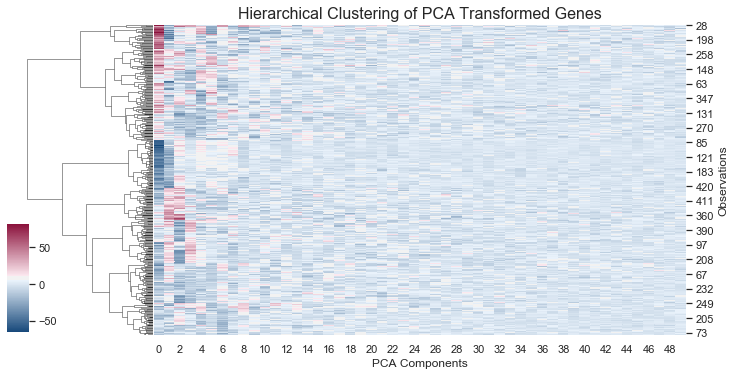

In [9]:
cmap = sns.diverging_palette(h_neg=250, h_pos=360, s=90, l=30, as_cmap=True)
g = sns.clustermap(transformedX, col_cluster=False, method='ward', figsize=(10, 5), cmap=cmap, 
                   cbar_pos=(0, 0.1, 0.03, 0.3), dendrogram_ratio=(0.2, 0))

g.ax_heatmap.set_title("Hierarchical Clustering of PCA Transformed Genes", fontsize=16)
g.ax_heatmap.set_xlabel("PCA Components")
g.ax_heatmap.set_ylabel("Observations")
plt.show()

From the heatmap of the PCA transformed genes, there appears to be a group with very high values, a group with very low values, and a group with moderately low values in the first component.  

In [10]:
# borrowed from here
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
# #sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [11]:
# fit model
model = cluster.AgglomerativeClustering(n_clusters=None , distance_threshold=450)
hiermodel = model.fit(transformedX) 

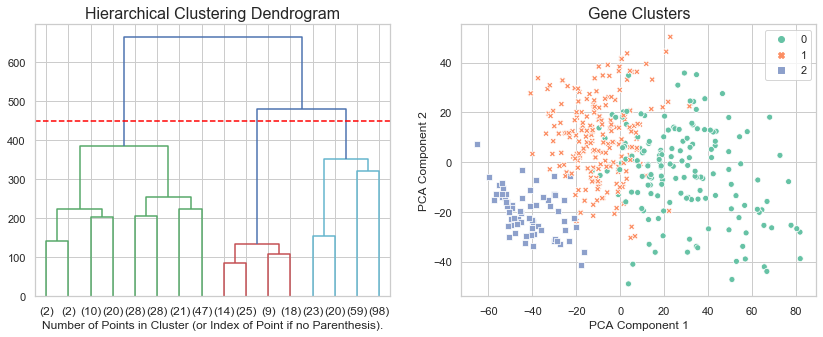

In [12]:
# plot cluster graphs
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

plot_dendrogram(model, truncate_mode='level', p=3, leaf_font_size=12, ax=axs[0])
axs[0].axhline(y=450, c='red', ls="--")
axs[0].set_title('Hierarchical Clustering Dendrogram', fontsize=16)
axs[0].set_xlabel("Number of Points in Cluster (or Index of Point if no Parenthesis).")

cmap = sns.cubehelix_palette(dark=.1, light=.8, as_cmap=True)
sns.scatterplot(x=graphingX[:,0], y=graphingX[:,1], style=hiermodel.labels_, 
                hue=hiermodel.labels_, palette="Set2", ax=axs[1])
axs[1].set_xlabel("PCA Component 1")
axs[1].set_ylabel("PCA Component 2")
axs[1].set_title("Gene Clusters", fontsize=16)

plt.show()

In [13]:
# get cluster assignment
gene_data["Cluster"] = hiermodel.labels_

# merge link data with cluster assignments
link_data = links[["Case ID", "File Name"]].rename(columns={"Case ID": "submitter_id", 
                                                            "File Name": "FileName"})
link_data = link_data.merge(gene_data[["FileName", "Cluster"]], on="FileName")

# merge links with medical data
# some people have the same submitter_id, no guarantees on correct merge for some of them
medical_data = link_data.merge(clinical, on="submitter_id")

# create variables for survival analysis
medical_data["Dead"] = [1 if x == "Dead" else 0 for x in medical_data["vital_status"]]

days_survived = []
for i, r in medical_data.iterrows():
    if r["vital_status"] == "Dead":
        days_survived.append(r["days_to_death"])
    else:
        days_survived.append(r["days_to_last_follow_up"])
medical_data["days_survived"] = days_survived
medical_data["days_survived"] = medical_data["days_survived"].astype('int64')

In [14]:
results = ll.statistics.multivariate_logrank_test(medical_data["days_survived"], 
                                                  groups=medical_data["Cluster"], 
                                                  event_observed=medical_data["Dead"])

latex = results.summary.to_latex(index=False)
display({'text/latex': latex}, raw = True)

Using a multivariate logrank test, the p-value is less that 0.05, meaning we have significant evidence that at least two groups have different survival distributions.

## Survival Time Comparison

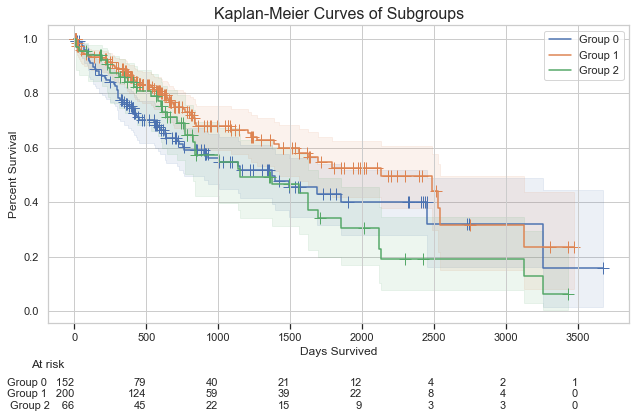

In [22]:
fix, axs = plt.subplots(figsize=(9, 6))

kmf0 = ll.KaplanMeierFitter()
cluster_data = medical_data[medical_data["Cluster"] == 0].reset_index(drop=True)
kmf0.fit(cluster_data["days_survived"], event_observed=cluster_data["Dead"], label="Group 0")
kmf0.plot(show_censors=True, ci_alpha=0.1, ax=axs)

kmf1 = ll.KaplanMeierFitter()
cluster_data = medical_data[medical_data["Cluster"] == 1].reset_index(drop=True)
kmf1.fit(cluster_data["days_survived"], event_observed=cluster_data["Dead"], label="Group 1")
kmf1.plot(show_censors=True, ci_alpha=0.1, ax=axs)

kmf2 = ll.KaplanMeierFitter()
cluster_data = medical_data[medical_data["Cluster"] == 2].reset_index(drop=True)
kmf2.fit(cluster_data["days_survived"], event_observed=cluster_data["Dead"], label="Group 2")
kmf2.plot(show_censors=True, ci_alpha=0.1, ax=axs)
        
ll.plotting.add_at_risk_counts(kmf0, kmf1, kmf2, ax=axs)

axs.set_xlabel("Days Survived")
axs.set_ylabel("Percent Survival")
axs.set_title("Kaplan-Meier Curves of Subgroups", fontsize=16)
plt.tight_layout()
plt.show()

The Kaplan-Meier curves of the three groups all overlap in some places, although their shapes are somewhat different.  Group 0 has the least survival early on, although after the 1000 day mark its survival rate descends slower.  Group 1 has a better survival rate than Group 0 up until the 2500 day mark, when its survival rate becomes relatively the same as Group 0, so people in Group 1 tend to have a better short term survival rate than the other groups, although in the long term its relatively the same.  Group 2 has a similar survival rate to Group 1 until the 800 day mark, when its survival rate decreases much faster than Group 0 and 1, and it has the lowest survival rate in the long term.

## Survival Regression

In [16]:
cph = ll.CoxPHFitter()

regressionX = pd.concat([medical_data, pd.get_dummies(medical_data[["Sex"]])], axis=1)
regressionX = regressionX.drop(columns=["submitter_id", "FileName", "Sex", "vital_status", 
                                        "days_to_death", "days_to_last_follow_up"])

# encode tumor_stage as numbers since using dummies causes LinAlg errors
tumor_stage = []
for stage in regressionX["tumor_stage"]:
    if stage == "stage i":
        tumor_stage.append(1)
    elif stage == "stage ii":
        tumor_stage.append(2)
    elif stage == "stage iii":
        tumor_stage.append(3)
    elif stage == "stage iiia":
        tumor_stage.append(3)
    elif stage == "stage iiib":
        tumor_stage.append(3)
    elif stage == "stage iiic":
        tumor_stage.append(3)
    elif stage == "stage iv":
        tumor_stage.append(4)
    elif stage == "stage iva":
        tumor_stage.append(4)
    elif stage == "stage ivb":
        tumor_stage.append(4)
    elif stage == "not reported":
        tumor_stage.append(np.nan)

regressionX["TumorStage"] = tumor_stage

# drop unneeded, and also observations where tumor stage is not reported
regressionX = regressionX.drop(columns=["Sex_male", "tumor_stage"])
regressionX = regressionX[regressionX["TumorStage"].notna()]

In [17]:
# get coefficients and ranges for plotting
coef_df = pd.DataFrame(columns=['coef', 'err', 'varname', 'cluster'])

for i in range(hiermodel.n_clusters_):
    cluster_data = regressionX[regressionX["Cluster"] == i].reset_index(drop=True).drop(columns="Cluster")
    cph.fit(cluster_data, duration_col='days_survived', event_col='Dead')
    
    err_len = cph.params_ - cph.confidence_intervals_["95% lower-bound"]
    new_coefs = pd.DataFrame({'coef': cph.params_, 'err': err_len, 
                              'varname': cph.params_.index, 
                              'cluster': np.repeat(i, 3)})
    coef_df = coef_df.append(new_coefs)

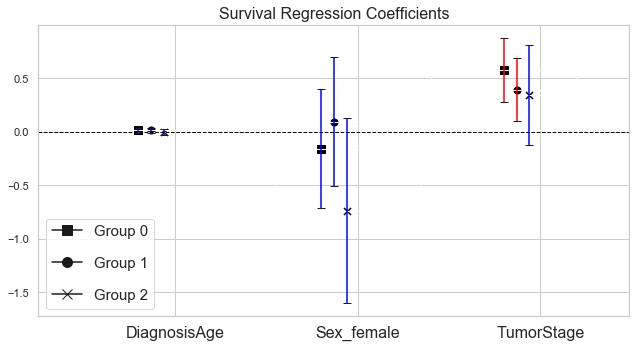

In [21]:
marker_list = 'sox'
width=0.07

# 3 covariates
base_x = np.arange(3) - 0.2

fig, axs = plt.subplots(figsize=(9, 5))
blue = (0, 0, 1, 1)
red = (1, 0, 0, 1)

for c in range(hiermodel.n_clusters_):
    curr_data = coef_df[coef_df["cluster"] == c].reset_index(drop=True)
    
    #  offset x posistions
    x_positions = base_x + width * c
    
    # color lines by whether they're significant or not
    colors = []
    for i, r in curr_data.iterrows():
        if r["coef"] - r["err"] > 0:
            colors.append(red)
        if r["coef"] + r["err"] < 0:
            colors.append(red)
        else:
            colors.append(blue)
    
    bar = axs.bar(x_positions, curr_data['coef'], color='none', yerr=curr_data['err'], capsize=4)
    bar.errorbar.lines[2][0].set_color(colors)
    
    axs.set_ylabel('')
    axs.set_xlabel('')
    
    axs.scatter(x=x_positions, y=curr_data['coef'], marker=marker_list[c], s=50, color='black') # change markers
    
axs.axhline(y=0, linestyle='--', color='black', linewidth=1)
axs.xaxis.set_ticks_position('none')
axs.set_xticks(base_x + 0.2)
_ = axs.set_xticklabels(cph.params_.index, rotation=0, fontsize=16)

# make legend
legend_elements = [mpl.lines.Line2D([0], [0], marker=m, label='Group %d'%i, color = 'k', markersize=10)
                   for i, m in enumerate(marker_list)]
_ = axs.legend(handles=legend_elements, loc=3, prop={'size': 15}, labelspacing=1.2)

plt.title("Survival Regression Coefficients", fontsize=16)
plt.tight_layout()
plt.show()

I conducted a Cox regression using age at diagnosis, sex, and tumor stage as predictors for survival time and plotted the regression coefficients and their confidence intervals.  Age at diagnosis and Sex both result in no significant predictors.  Tumor stage appears to be significant for group 0 and 1, but not group 2.  However, the confidence intervals for both group 0 and 1 overlap by quite a lot with eachother and with group 2, and it's possibly due to how group 2 has much less data in it than group 0 and 1 which resulted in a larger confidence interval and it being the only one whose coefficient for tumor stage wasn't significant.  Since all the confidence intervals overlap greatly, it doesn't seem as though the effects of tumor stage vary group to group either.  The significant coefficient implies that an increase in tumor stage results in an increased risk of death.

## Distribution of Predictors within Groups

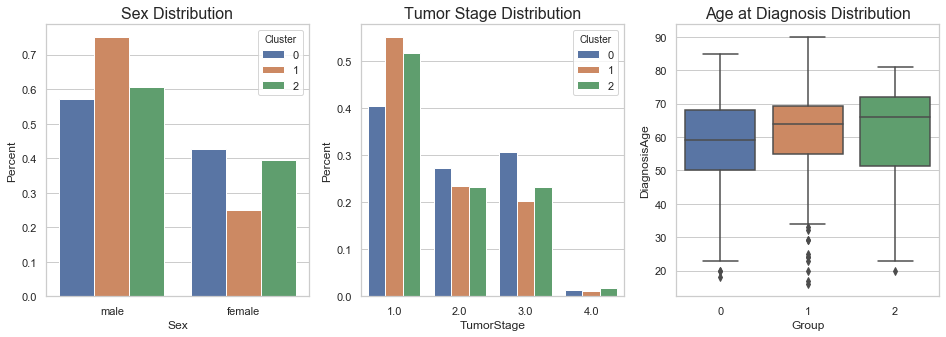

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

genders = medical_data.groupby("Cluster")["Sex"].value_counts(normalize=True).rename("Percent").reset_index()
sns.barplot(x="Sex", y="Percent", hue="Cluster", data=genders, ax=axs[0])
axs[0].set_title("Sex Distribution", fontsize=16)

stages = regressionX.groupby("Cluster")["TumorStage"].value_counts(normalize=True).rename("Percent").reset_index()
sns.barplot(x="TumorStage", y="Percent", hue="Cluster", data=stages, ax=axs[1])
axs[1].set_title("Tumor Stage Distribution", fontsize=16)

sns.boxplot(x="Cluster", y="DiagnosisAge", data=medical_data, ax=axs[2])
axs[2].set_xlabel("Group")
axs[2].set_title("Age at Diagnosis Distribution", fontsize=16)

plt.show()

There appears to be higher percentage of males in group 1 than the other groups.  There also appears to be a lower percentage of tumor stage one patients in group 0, with a corresponding larger percentage of tumor stage two and three patients.  There doesn't appear to be any significant differences in distribution of age between the groups.

# Conclusion

There appear to be three types of patients with liver cancer, identified by their similarity in gene counts.  Group 0 appears to have relatively high values for the PCA-transformed component one, and a lower short term survival rate.  Group 1 appears to have moderately low values for the PCA-transformed component one, and a higher short term survival rate but around the same long term survival rate as Group 0.  Group 2 appears to have very low values for the PCA-transformed component one, and a high short term survival rate but a much lower long term survival rate than the other groups.

Both age at diagnosis and sex don't appear to have any significant effects on the survival rate of a patient with liver cancer.  Tumor stage does seem to have an effect, with a higher tumor stage resulting in a higher death rate in groups 0 and 1.  Group 2's coefficient for tumor stage isn't significant, but its confidence interval contains both group 0 and 1's coefficients, so its possible that tumor stage also affects it in the same way.  Tumor stage having an effect makes sense, since a more severe tumor would seem to imply more serious symptoms and a higher chance of death.  The effects of an increase in tumor stage doesn't seem to vary from group to group though, so none of the predictors seem to have different effects between groups.  

There is a slightly higher percentage of males in group 1 than the other groups, and a slightly higher percentage of people with tumor stage three in group 0, which could be why group 0 has a lower short term survival rate.  Maybe future analysis could try and see if the higher percentage of people with tumor stage three in group 0 is a coincidence, or if people with these types of genes really are more at risk of developing a tumor at stage three.  It isn't a particularly large difference in percentage from the other groups though.  Overall the type of people in each group doesn't appear to be significantly different, and perhaps more cases of liver cancer could help uncover if this is a trend or a coincidence.

## General Considerations

There is an imbalance in the number of points in each group, with 158 in group 0, 200 in group 1, and 66 in group 2.  I've taken the percentage of counts when viewing the distributions of predictors in each groups to alleviate this, although this might be what resulted in the coefficient for Tumor Stage in group 2 not being significant, when it was for group 0 and 1.

The clinical information and gene data is merged on the clinical information's submitter id and the gene data's case id.  While submitter id in the clinical information is unique, the case id linked to the gene data has quite a few cases of ids appearing 2 times, so it is likely some pairs of patients end up with the same clinical information when merging the dataframes.  It's unclear if this means one person had their gene counts taken multiple times with different results, or if it does refer to two different people but only one of their clinical information was logged in the database.

Since clustering was done on the PCA-transformed data, it's hard to interpret exactly what effect any gene has in creating the differences in the PCA transformed gene counts.  Further analysis could be done with a biologist in viewing the genes most involved in creating the variation in clustering and seeing if the groups found in the gene counts appear to make sense.  As well, there is much less data of patients with higher tumor stages, so adding more of those would help assess the effects of tumor stage between the groups.